NETTOYAGE DE DONNÉES

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from xgboost import XGBClassifier
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:
# Data validation utilities
def validate_dataframe(df, name="DataFrame"):
    """Validate DataFrame quality and report statistics."""
    print(f"\n{'='*50}")
    print(f"Validation: {name}")
    print(f"{'='*50}")
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
    print(f"Missing values: {df.isnull().sum().sum()}")
    print(f"Duplicate rows: {df.duplicated().sum()}")
    print(f"Data types: {df.dtypes.value_counts().to_dict()}")
    
    if df.select_dtypes(include=[np.number]).shape[1] > 0:
        numeric_df = df.select_dtypes(include=[np.number])
        print(f"Numeric columns: {numeric_df.shape[1]}")
        print(f"  - Mean range: [{numeric_df.mean().min():.2e}, {numeric_df.mean().max():.2e}]")
        print(f"  - Std range: [{numeric_df.std().min():.2e}, {numeric_df.std().max():.2e}]")
    
    print(f"{'='*50}\n")
    return df

def check_class_balance(y, label_name="Labels"):
    """Check and report class distribution."""
    counts = y.value_counts()
    print(f"\n{label_name} distribution:")
    for label, count in counts.items():
        percentage = (count / len(y)) * 100
        print(f"  {label}: {count} ({percentage:.1f}%)")
    
    # Check for severe imbalance
    if len(counts) > 1:
        ratio = counts.max() / counts.min()
        if ratio > 3:
            print(f"⚠ Warning: Class imbalance detected (ratio {ratio:.1f}:1)")
    return counts


In [3]:
# Use relative path from notebooks/ to data/
file_path = Path("../data/GSE19804_series_matrix.txt")

# Check if file exists
if not file_path.exists():
    print(f"Error: File not found at {file_path}")
    print(f"Please ensure the data file is in the data/ directory")
    sys.exit(1)

# Lire les lignes utiles
try:
    with open(file_path, 'rt') as f:
        lines = f.readlines()
except Exception as e:
    print(f"Error reading file: {e}")
    sys.exit(1)

# Identifier les lignes de début et de fin de la matrice de données
start = None
end = None
for i, line in enumerate(lines):
    if line.startswith("!series_matrix_table_begin"):  # Ligne de début de la matrice
        start = i + 1  # On ignore les lignes de métadonnées
    elif line.startswith("!series_matrix_table_end"):  # Ligne de fin de la matrice
        end = i
        break

if start is None or end is None:
    print("Error: Could not find data matrix markers in file")
    sys.exit(1)

# Lire la matrice de données
df = pd.read_csv(file_path, sep="\t", skiprows=start, nrows=end - start - 1, index_col=0, comment="!")
print(f"✓ Data loaded successfully: {df.shape[0]} genes, {df.shape[1]} samples")
df.head()


✓ Data loaded successfully: 54675 genes, 120 samples


,GSM494556,GSM494557,GSM494558,GSM494559,GSM494560,GSM494561,GSM494562,GSM494563,GSM494564,GSM494565,...,GSM494666,GSM494667,GSM494668,GSM494669,GSM494670,GSM494671,GSM494672,GSM494673,GSM494674,GSM494675
ID_REF,,,,,,,,,,,,,,,,,,,,,
1007_s_at,11.96280,11.38780,11.19280,11.90360,11.75230,11.04240,10.74160,11.71090,11.46260,11.49050,...,10.35930,10.55280,10.81930,10.97170,10.38300,10.60120,11.19790,10.84320,10.60670,9.37942
1053_at,7.05652,7.33711,7.26121,7.91211,8.27448,7.60698,9.80415,8.85862,7.80342,8.43741,...,7.69447,7.80456,7.87718,7.64986,7.80042,7.92790,7.85849,7.91834,8.05853,7.51433
117_at,6.55585,6.96023,7.14488,7.13887,7.72479,8.01441,8.88544,7.99740,7.33263,10.54530,...,7.44120,7.82203,8.46291,7.68880,9.54127,8.62987,7.88748,7.85222,7.24397,8.83099
121_at,8.43850,8.51636,8.43138,8.67404,8.78145,8.55224,8.86868,8.15469,8.72485,8.13286,...,8.33440,8.18781,8.46548,8.23930,8.60798,8.59521,8.66340,8.33596,8.66742,8.46711
1255_g_at,3.73169,3.77978,3.99853,3.69171,3.93509,3.54508,4.14981,6.99991,4.38131,4.05949,...,3.73375,3.59215,3.74585,3.73324,3.65606,3.71172,3.84361,3.75038,3.87179,3.71853


In [4]:
print(f"Shape: {df.shape}")
print(f"Samples: {df.columns[:5]}")

# Remove columns with missing names
df = df.loc[:, df.columns.notna()]
print(f"✓ Removed columns with missing names: {df.shape}")

# Remove duplicate gene rows
df = df[~df.index.duplicated(keep='first')]
print(f"✓ Removed duplicate genes: {df.shape}")

# Convert all values to numeric
df = df.apply(pd.to_numeric, errors='coerce')

# Check for missing values
missing_count = df.isnull().sum().sum()
print(f"⚠ Missing values found: {missing_count}")

if missing_count > 0:
    # Count missing per row and column
    missing_per_row = df.isnull().sum(axis=1)
    missing_per_col = df.isnull().sum(axis=0)
    print(f"  - Genes with missing values: {(missing_per_row > 0).sum()}")
    print(f"  - Samples with missing values: {(missing_per_col > 0).sum()}")


Shape: (54675, 120)
Samples: Index(['GSM494556', 'GSM494557', 'GSM494558', 'GSM494559', 'GSM494560'], dtype='object')
✓ Removed columns with missing names: (54675, 120)
✓ Removed duplicate genes: (54675, 120)
⚠ Missing values found: 0


In [5]:
# Strategy: Remove genes (rows) with any missing values
# Keep all samples (columns) since they're our observations
df_clean = df.dropna(axis=0)  # axis=0 removes rows (genes) with NaN
print(f"✓ Removed genes with missing values: {df.shape[0]} → {df_clean.shape[0]} genes")

# Remove genes (columns after transpose) with all zeros (no expression)
df_clean = df_clean.loc[:, (df_clean != 0).any(axis=0)]
print(f"✓ Removed zero-expression genes: {df_clean.shape}")

# Transpose: samples as rows, genes as columns
df_T = df_clean.T
print(f"✓ Transposed data: {df_T.shape[0]} samples × {df_T.shape[1]} genes")

# Standardize features (Z-score normalization)
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_T), 
    index=df_T.index, 
    columns=df_T.columns
)

# Verify cleaning
print(f"\n✓ Final cleaned data: {df_scaled.shape}")
print(f"✓ Missing values: {df_scaled.isnull().sum().sum()}")
print(f"✓ Mean: {df_scaled.mean().mean():.2e} (should be ~0)")
print(f"✓ Std: {df_scaled.std().mean():.2f} (should be ~1)")


✓ Removed genes with missing values: 54675 → 54675 genes
✓ Removed zero-expression genes: (54675, 120)
✓ Transposed data: 120 samples × 54675 genes

✓ Final cleaned data: (120, 54675)
✓ Missing values: 0
✓ Mean: -1.09e-16 (should be ~0)
✓ Std: 1.00 (should be ~1)

✓ Final cleaned data: (120, 54675)
✓ Missing values: 0
✓ Mean: -1.09e-16 (should be ~0)
✓ Std: 1.00 (should be ~1)


In [6]:
# Réduction à 2 dimensions pour la visualisation
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(df_scaled)

# Variance expliquée
explained_var = pca.explained_variance_ratio_
print(f"Variance expliquée par PC1: {explained_var[0]:.2%}")
print(f"Variance expliquée par PC2: {explained_var[1]:.2%}")
print(f"Variance totale expliquée: {explained_var.sum():.2%}")

# Stocker la projection avec l'index des échantillons
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=df_scaled.index)
print(f"\n✓ PCA projection: {df_pca.shape}")


Variance expliquée par PC1: 16.07%
Variance expliquée par PC2: 11.06%
Variance totale expliquée: 27.13%

✓ PCA projection: (120, 2)


DÉTECTION D’ANOMALIES PAR IsolationForest

In [7]:
# Initialiser le modèle Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination = 0.1, random_state=42)

# Entraînement du modèle sur les données standardisées
iso_forest.fit(df_scaled)

# Prédiction des anomalies : -1 = anomalie, 1 = normal
df_pca['Anomaly_IF'] = iso_forest.predict(df_scaled)


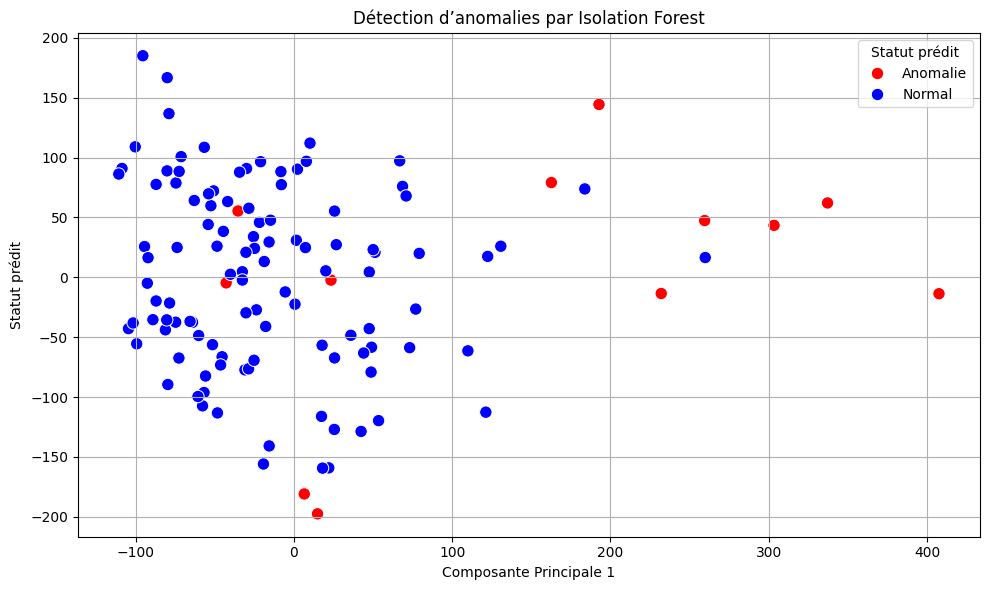

In [8]:
# Créer une nouvelle colonne texte pour affichage
df_pca['Anomaly_Label'] = df_pca['Anomaly_IF'].map({1: "Normal", -1: "Anomalie"})

# Utiliser cette colonne pour la couleur
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_pca, # DataFrame avec les composantes principales et les étiquettes d'anomalies
    x='PC1', y='PC2',  # Composantes principales pour les axes
    hue='Anomaly_Label',  # Couleur basée sur l'étiquette d'anomalie
    palette={"Normal": "blue", "Anomalie": "red"},  # Palette de couleurs pour les étiquettes
    s=80 # Taille des points
)

plt.title("Détection d’anomalies par Isolation Forest")
plt.xlabel("Composante Principale 1")
plt.ylabel("Statut prédit")
plt.legend(title="Statut prédit")
plt.grid(True)
plt.tight_layout()
plt.show()


DÉTECTION D’ANOMALIES PAR AUTOENCODEUR

In [9]:
# Taille d'entrée = nombre de gènes
n_features = df_scaled.shape[1]
# Architecture de l'autoencodeur
input_layer = Input(shape=(n_features,)) # Entrée de l'autoencodeur avec le nombre de gènes comme dimension
encoded = Dense(64, activation='relu')(input_layer) # Couche cachée avec 64 neurones et activation ReLU
encoded = Dense(32, activation='relu')(encoded) # Couche cachée avec 32 neurones et activation ReLU
decoded = Dense(64, activation='relu')(encoded) # Couche cachée avec 64 neurones et activation ReLU
output_layer = Dense(n_features, activation='linear')(decoded) # Couche de sortie avec le même nombre de neurones que l'entrée et activation linéaire

# Modèle de l'autoencodeur  
autoencoder = Model(inputs=input_layer, outputs=output_layer) # Création du modèle de l'autoencodeur avec les couches définies
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse') # Compilation du modèle avec l'optimiseur Adam et la fonction de perte MSE (erreur quadratique moyenne)

# Entraînement sur données normales
history = autoencoder.fit(
    df_scaled, df_scaled, # Entraînement de l'autoencodeur sur les données standardisées
    epochs=50, # Nombre d'époques pour l'entraînement
    batch_size=16, # Taille du lot pour l'entraînement
    shuffle=True, # Mélanger les données à chaque époque
    validation_split=0.1, # Fraction des données à utiliser pour la validation
    verbose=0 # Afficher les informations d'entraînement (0 pour silencieux, 1 pour afficher la progression, 2 pour afficher uniquement les erreurs)
)


In [10]:
# Reconstruction
reconstructed = autoencoder.predict(df_scaled)
# Erreur quadratique moyenne par échantillon
reconstruction_error = np.mean(np.square(df_scaled - reconstructed), axis=1)
# Ajouter au DataFrame PCA 
df_pca['Reconstruction_Error'] = reconstruction_error


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [11]:
# Reconstruction du df_pca avec index aligné
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"], index=df_scaled.index)

# Ajouter l’erreur de reconstruction
df_pca['Reconstruction_Error'] = reconstruction_error

# Ajouter les prédictions Isolation Forest
df_pca['Anomaly_IF'] = iso_forest.predict(df_scaled).astype(int)

# Détection AE : seuil basé sur le 90e percentile
threshold = np.percentile(reconstruction_error, 90)

# Détection des anomalies : -1 = anomalie, 1 = normal
df_pca['Anomaly_AE'] = (df_pca['Reconstruction_Error'] > threshold).astype(int)
df_pca['Anomaly_AE'] = df_pca['Anomaly_AE'].map({0: 1, 1: -1})  # alignement avec Isolation Forest

# Ajouter un label lisible
df_pca['AE_Label'] = df_pca['Anomaly_AE'].map({1: "Normal", -1: "Anomalie"})


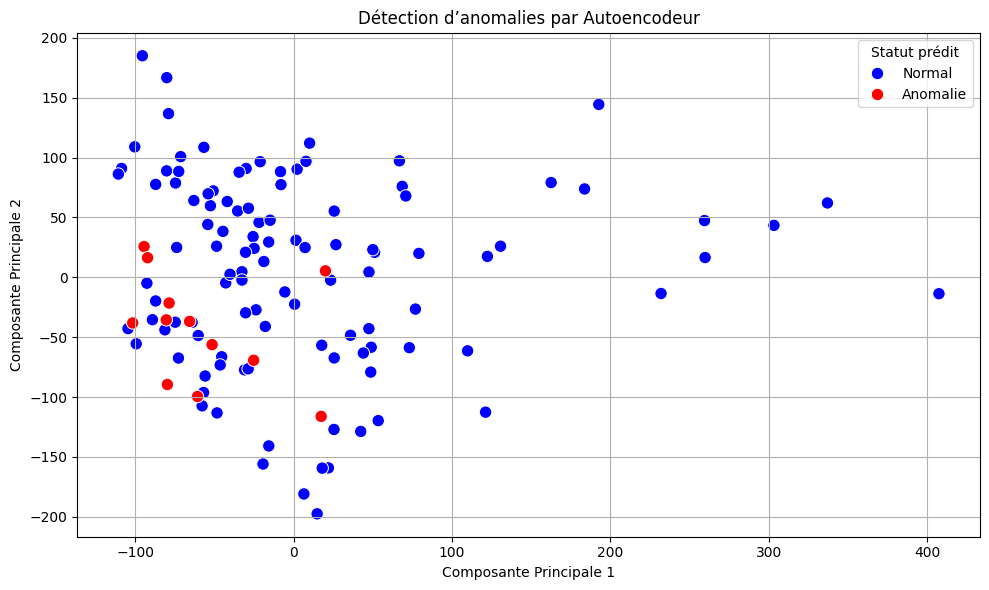

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_pca,
    x='PC1', y='PC2',
    hue='AE_Label',
    palette={"Normal": "blue", "Anomalie": "red"},
    s=80
)

plt.title("Détection d’anomalies par Autoencodeur")
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.legend(title="Statut prédit")
plt.grid(True)
plt.tight_layout()
plt.show()


DÉTECTION D’ANOMALIES PAR LOCAL OUTLIER FACTOR (LOF)

In [13]:
# Initialiser le modèle
lof = LocalOutlierFactor(
    n_neighbors=20,      # nombre de voisins (par défaut)
    contamination=0.1,   # proportion d’anomalies estimée
    novelty=False        # mode "fit_predict" uniquement
)
# Prédiction directe (pas d'entraînement séparé avec LOF)
lof_preds = lof.fit_predict(df_scaled)  # -1 = anomalie, 1 = normal
# Ajout au DataFrame PCA
df_pca['Anomaly_LOF'] = lof_preds 
df_pca['LOF_Label'] = df_pca['Anomaly_LOF'].map({1: "Normal", -1: "Anomalie"})


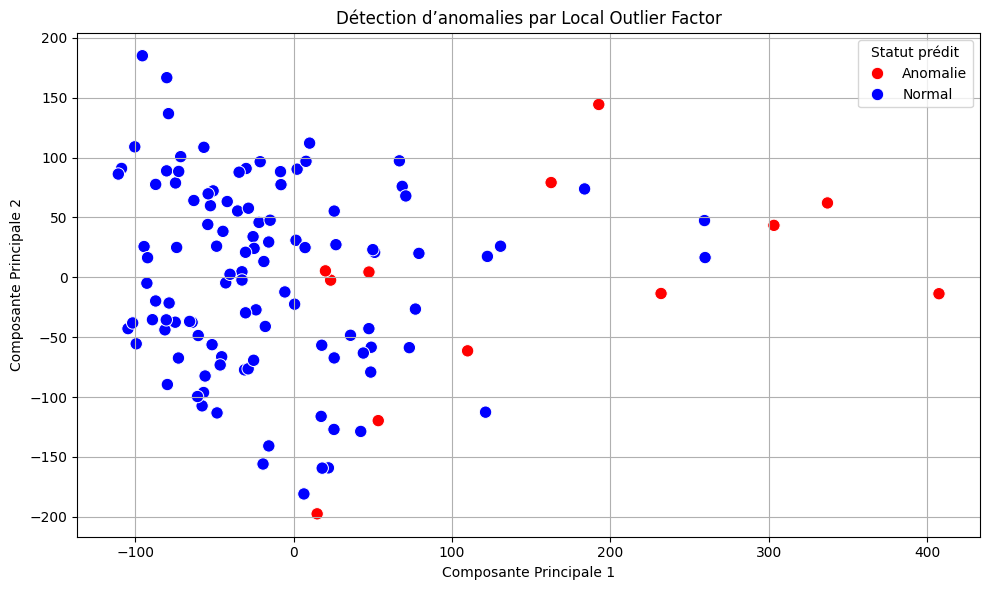

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_pca,
    x='PC1', y='PC2',
    hue='LOF_Label',
    palette={"Normal": "blue", "Anomalie": "red"},
    s=80
)

plt.title("Détection d’anomalies par Local Outlier Factor")
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.legend(title="Statut prédit")
plt.grid(True)
plt.tight_layout()
plt.show()


COMPARAISON DES MODÈLES PAR RAPPORT À LA VÉRITÉ

In [ ]:
# Extract sample metadata from original file
sample_ids = []
sample_labels = []

# Extract sample IDs
for line in lines:
    if line.startswith("!Sample_geo_accession"):
        sample_ids = [x.replace('"', '').strip() for x in line.strip().split("\t")[1:]]
        break

if not sample_ids:
    print("⚠ Warning: No sample IDs found in file")

# Extract sample labels from titles
for line in lines:
    if line.startswith("!Sample_title"):
        titles = line.strip().split("\t")[1:]
        for title in titles:
            t = title.lower()
            if "normal" in t:
                sample_labels.append("Sain")
            elif "cancer" in t or "tumor" in t:
                sample_labels.append("Cancer")
            else:
                sample_labels.append("Inconnu")
        break

if not sample_labels:
    print("⚠ Warning: No sample labels found in file")
elif len(sample_ids) != len(sample_labels):
    print(f"⚠ Warning: Mismatch between IDs ({len(sample_ids)}) and labels ({len(sample_labels)})")

# Create mapping dictionary
sample_status = dict(zip(sample_ids, sample_labels))

# Map labels to dataframe
df_pca['Label'] = df_pca.index.map(sample_status)

# Check for unmapped samples
unmapped = df_pca['Label'].isna().sum()
if unmapped > 0:
    print(f"⚠ Warning: {unmapped} samples could not be mapped to labels")

# Display distribution
print("\n✓ Sample label distribution:")
print(df_pca['Label'].value_counts(dropna=False))


Label
Cancer    60
Sain      60
Name: count, dtype: int64
Les colonnes du DataFrame df_pca sont: Index(['PC1', 'PC2', 'Reconstruction_Error', 'Anomaly_IF', 'Anomaly_AE',
       'AE_Label', 'Anomaly_LOF', 'LOF_Label', 'Label'],
      dtype='object')


In [ ]:
def eval_modele(anomaly_col, nom_modele):
    """Evaluate unsupervised anomaly detection model against true labels."""
    print(f"\n{'='*60}")
    print(f"Evaluation: {nom_modele}")
    print(f"{'='*60}")
    
    # Prepare evaluation dataframe
    df_eval = df_pca[['Label', anomaly_col]].copy()
    
    # Clean and standardize labels
    df_eval['Label_clean'] = df_eval['Label'].astype(str).str.lower().str.strip()
    df_eval['Label_clean'] = df_eval['Label_clean'].replace({
        'cancer': 'Cancer',
        'normal': 'Sain', 
        'tumor': 'Cancer',
        'sain': 'Sain'
    })
    
    # Filter valid data only
    data = df_eval[df_eval['Label_clean'].isin(['Cancer', 'Sain'])].copy()
    
    if data.empty:
        print("⚠ No usable data for evaluation")
        return None
    
    print(f"Evaluating on {len(data)} samples")
    
    # Convert to binary: 1 = Cancer, 0 = Healthy
    y_true = data['Label_clean'].map({'Cancer': 1, 'Sain': 0})
    y_pred = data[anomaly_col].map({-1: 1, 1: 0})  # -1 (anomaly) = Cancer
    
    # Check for conversion issues
    if y_pred.isna().any():
        print(f"⚠ Warning: {y_pred.isna().sum()} predictions could not be converted")
    
    try:
        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        print("\nConfusion Matrix:")
        print(cm)
        
        # Classification report
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=["Sain", "Cancer"], zero_division=0))
        
        return {'confusion_matrix': cm, 'y_true': y_true, 'y_pred': y_pred}
        
    except Exception as e:
        print(f"✗ Error during evaluation: {e}")
        return None

# Note: Call this function for each model
# Example: eval_modele('Anomaly_IF', 'Isolation Forest')


In [17]:
eval_modele('Anomaly_IF', 'Isolation Forest') # Évaluation du modèle Isolation Forest



 Isolation Forest
Matrice de confusion :
[[58  2]
 [50 10]]

Rapport de classification :
              precision    recall  f1-score   support

        Sain       0.54      0.97      0.69        60
      Cancer       0.83      0.17      0.28        60

    accuracy                           0.57       120
   macro avg       0.69      0.57      0.48       120
weighted avg       0.69      0.57      0.48       120



In [18]:
eval_modele('Anomaly_AE', 'Autoencodeur') # Évaluation du modèle Autoencodeur


 Autoencodeur
Matrice de confusion :
[[49 11]
 [59  1]]

Rapport de classification :
              precision    recall  f1-score   support

        Sain       0.45      0.82      0.58        60
      Cancer       0.08      0.02      0.03        60

    accuracy                           0.42       120
   macro avg       0.27      0.42      0.31       120
weighted avg       0.27      0.42      0.31       120



In [19]:
eval_modele('Anomaly_LOF', 'Local Outlier Factor') # Évaluation du modèle Local Outlier Factor


 Local Outlier Factor
Matrice de confusion :
[[56  4]
 [52  8]]

Rapport de classification :
              precision    recall  f1-score   support

        Sain       0.52      0.93      0.67        60
      Cancer       0.67      0.13      0.22        60

    accuracy                           0.53       120
   macro avg       0.59      0.53      0.44       120
weighted avg       0.59      0.53      0.44       120



| Modèle               | Accuracy | Recall Cancer | Précision Cancer | F1-score Cancer |
| -------------------- | -------- | ------------- | ---------------- | --------------- |
| **Isolation Forest** | 57%      | 17%           | 83%              | 28%             |
| **Autoencodeur**     | 42%      | **2%**        | **8%**           | **3%**          |
| **LOF**              | **53%**  | **13%**       | 67%              | **22%**         |


Pipeline supervisée:
Préparation des données pour classification


In [ ]:
# Prepare data for supervised learning
X = df_scaled.copy()

# Extract and clean labels
y = df_pca['Label'].astype(str).str.lower().str.strip()
y = y.replace({'cancer': 1, 'sain': 0, 'normal': 0})

# Remove samples with unknown labels
valid_mask = y.isin([0, 1])
X = X[valid_mask]
y = y[valid_mask].astype(int)

print(f"✓ Prepared supervised learning data:")
print(f"  - Features: {X.shape}")
print(f"  - Labels: {len(y)}")

# Check class balance
check_class_balance(y, "Class distribution")


In [ ]:
# Train/test split with stratification
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y
    )
    
    print("✓ Train/test split successful:")
    print(f"  - Training set: {X_train.shape[0]} samples")
    print(f"  - Test set: {X_test.shape[0]} samples")
    
    print("\n  Training set distribution:")
    check_class_balance(y_train, "Train")
    
    print("\n  Test set distribution:")
    check_class_balance(y_test, "Test")
    
except ValueError as e:
    print(f"✗ Error during train/test split: {e}")
    print("This may happen if one class has too few samples for stratification")


Répartition y_train :
 Label
1    48
0    48
Name: count, dtype: int64
Répartition y_test :
 Label
1    12
0    12
Name: count, dtype: int64


In [ ]:
# Train SVM model
print("Training SVM (Linear Kernel)...")

try:
    svm_model = SVC(kernel='linear', random_state=42)
    svm_model.fit(X_train, y_train)
    
    # Predictions
    y_pred_svm = svm_model.predict(X_test)
    
    print("✓ SVM training completed\n")
    
    # Evaluation
    print("="*60)
    print("SVM Evaluation Results")
    print("="*60)
    
    cm = confusion_matrix(y_test, y_pred_svm)
    print("\nConfusion Matrix:")
    print(cm)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_svm, target_names=["Sain", "Cancer"], zero_division=0))
    
    # Calculate accuracy
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(y_test, y_pred_svm)
    print(f"\nTest Accuracy: {accuracy:.2%}")
    
except Exception as e:
    print(f"✗ Error training SVM: {e}")
    import traceback
    traceback.print_exc()


Matrice de confusion :
[[11  1]
 [ 2 10]]

Rapport de classification :
              precision    recall  f1-score   support

        Sain       0.85      0.92      0.88        12
      Cancer       0.91      0.83      0.87        12

    accuracy                           0.88        24
   macro avg       0.88      0.88      0.87        24
weighted avg       0.88      0.88      0.87        24



Comparé aux modèles non supervisés :

| Métrique         | SVM Supervisé | IF (meilleur non sup) |
| ---------------- | ------------- | --------------------- |
| Recall Cancer    | **0.83**      | 0.17                  |
| Précision Cancer | 0.91          | **0.83**              |
| F1-score Cancer  | **0.87**      | 0.28                  |
| Accuracy         | **0.88**      | 0.57                  |


Modèle XGBoost : entraînement & évaluation


In [ ]:
# Train XGBoost model
print("Training XGBoost Classifier...")

try:
    xgb_model = XGBClassifier(
        eval_metric='logloss',
        random_state=42,
        use_label_encoder=False
    )
    
    xgb_model.fit(X_train, y_train)
    
    # Predictions
    y_pred_xgb = xgb_model.predict(X_test)
    
    print("✓ XGBoost training completed\n")
    
    # Evaluation
    print("="*60)
    print("XGBoost Evaluation Results")
    print("="*60)
    
    cm = confusion_matrix(y_test, y_pred_xgb)
    print("\nConfusion Matrix:")
    print(cm)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_xgb, target_names=["Sain", "Cancer"], zero_division=0))
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred_xgb)
    print(f"\nTest Accuracy: {accuracy:.2%}")
    
except Exception as e:
    print(f"✗ Error training XGBoost: {e}")
    import traceback
    traceback.print_exc()


Matrice de confusion (XGBoost) :
[[10  2]
 [ 1 11]]

Rapport de classification (XGBoost) :
              precision    recall  f1-score   support

        Sain       0.91      0.83      0.87        12
      Cancer       0.85      0.92      0.88        12

    accuracy                           0.88        24
   macro avg       0.88      0.88      0.87        24
weighted avg       0.88      0.88      0.87        24



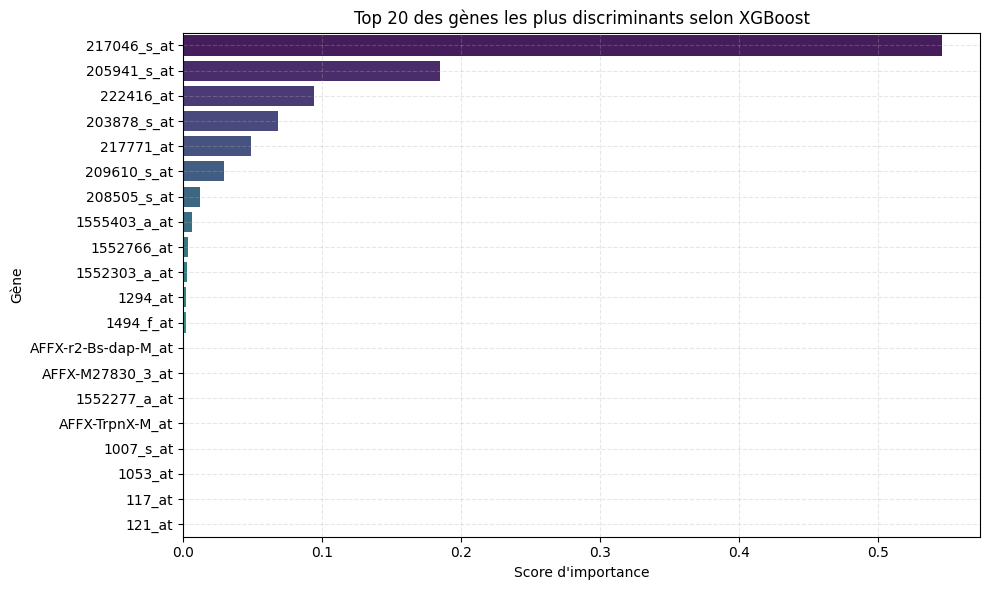

In [24]:
# Extraire les importances
importances = xgb_model.feature_importances_
feature_names = X.columns  # les noms des gènes

# Créer un DataFrame trié
feat_imp = pd.DataFrame({
    'Gène': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp, x='Importance', y='Gène', palette='viridis')
plt.title("Top 20 des gènes les plus discriminants selon XGBoost")
plt.xlabel("Score d'importance")
plt.ylabel("Gène")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()



Visualisation SVM vs XGBoost sur l’espace PCA

In [25]:
# Ajouter les prédictions dans df_pca (sur l’échantillon de test uniquement)
df_pca.loc[X_test.index, 'Pred_SVM'] = y_pred  # valeurs 0/1
df_pca.loc[X_test.index, 'Pred_XGB'] = y_pred_xgb 
# Ajouter des colonnes avec les labels lisibles pour SVM et XGBoost
df_pca['SVM_Label'] = df_pca['Pred_SVM'].map({1: 'Cancer', 0: 'Sain'}) 
df_pca['XGB_Label'] = df_pca['Pred_XGB'].map({1: 'Cancer', 0: 'Sain'}) 


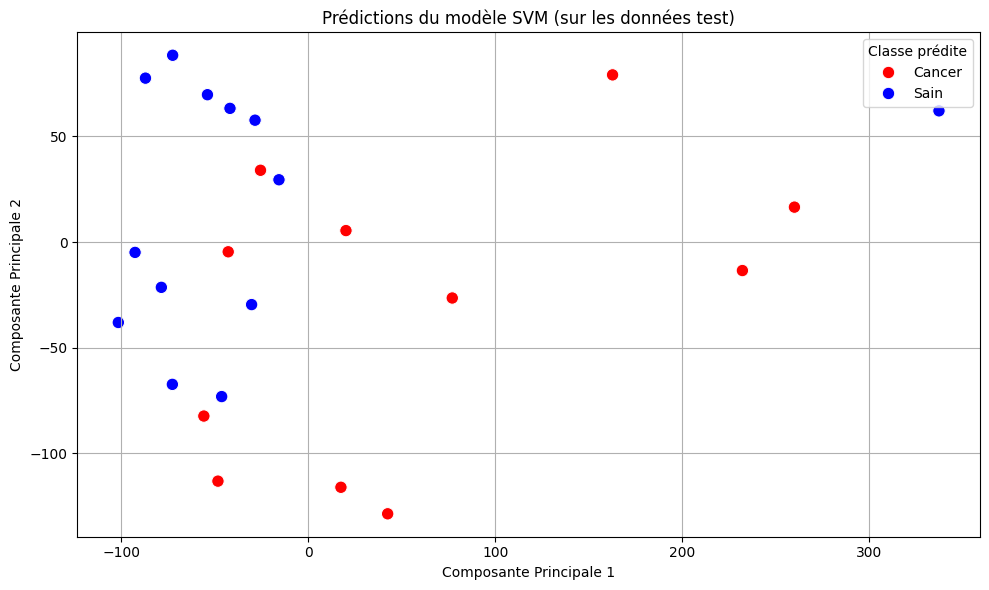

In [26]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_pca.loc[X_test.index],
    x='PC1', y='PC2',
    hue='SVM_Label',
    palette={'Sain': 'blue', 'Cancer': 'red'},
    s=80
)
plt.title("Prédictions du modèle SVM (sur les données test)")
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.legend(title="Classe prédite")
plt.grid(True)
plt.tight_layout()
plt.show()


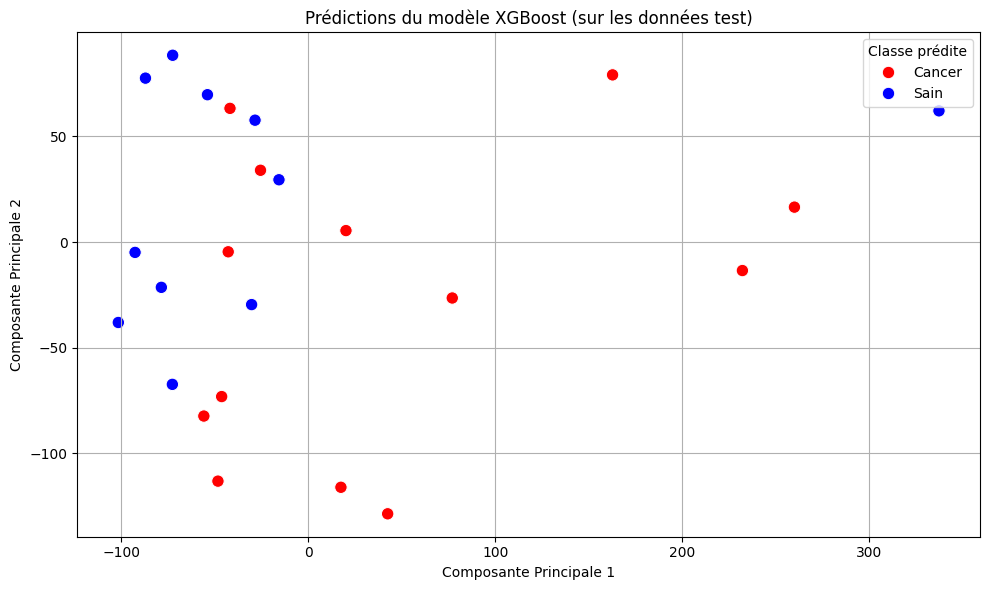

In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_pca.loc[X_test.index],
    x='PC1', y='PC2',
    hue='XGB_Label',
    palette={'Sain': 'blue', 'Cancer': 'red'},
    s=80
)
plt.title("Prédictions du modèle XGBoost (sur les données test)")
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.legend(title="Classe prédite")
plt.grid(True)
plt.tight_layout()
plt.show()


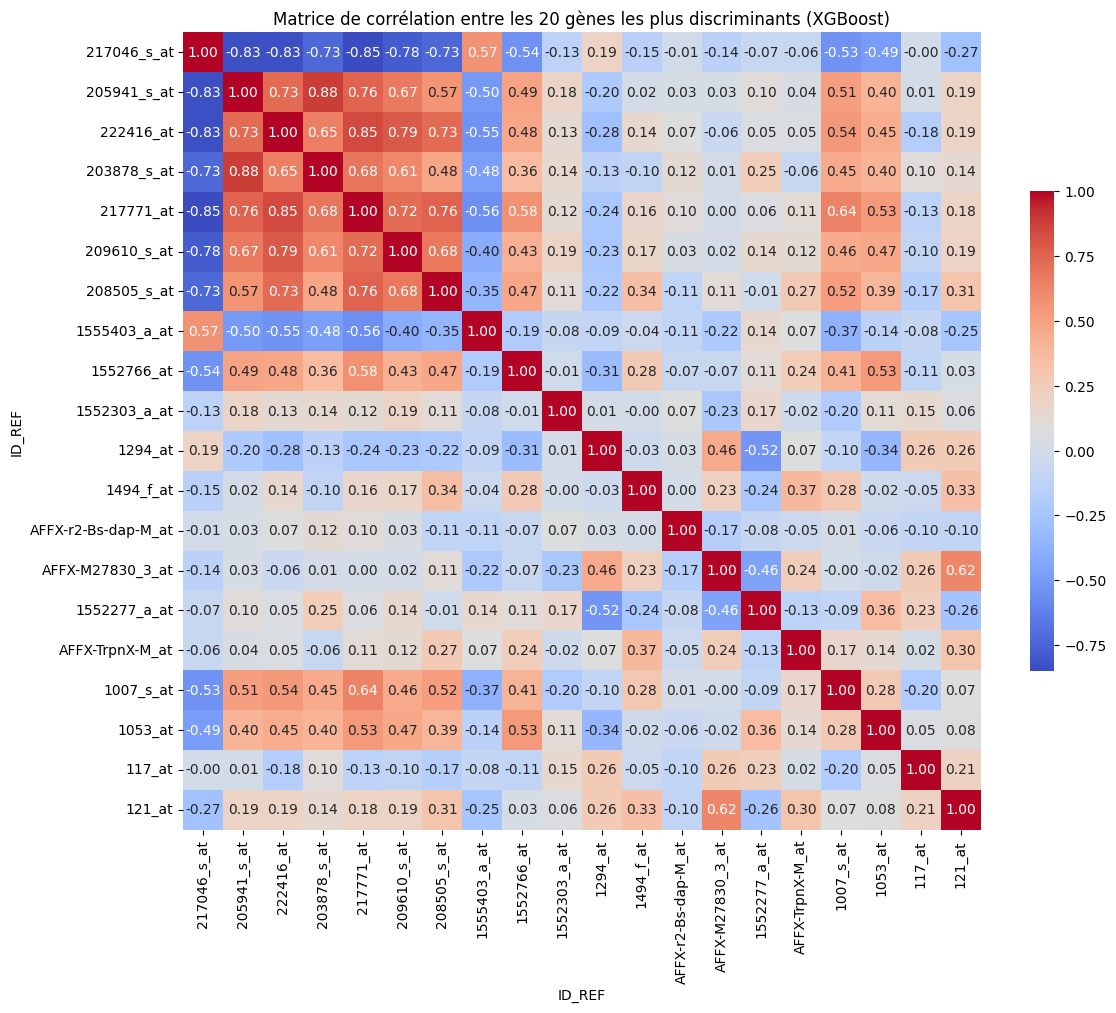

In [28]:
top_genes = feat_imp['Gène'].tolist()[:20]  # top 20 gènes

# Extraire leurs colonnes depuis df_scaled
X_subset = df_scaled[top_genes]

# Calcul de la matrice de corrélation
corr_matrix = X_subset.corr()

# Affichage avec seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .6})
plt.title("Matrice de corrélation entre les 20 gènes les plus discriminants (XGBoost)")
plt.tight_layout()
plt.show()
